[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/tut7_RNN_NLP1_teacher.ipynb)

# Tutorial 7: Processing words as sequences
In this tutorial, we will try to predict the next word in a sentence. This is challenging, as we will see because we choose a word out of a vocabulary, which is commonly large. Hence, the purpose of this tutorial is not to get an accurate model, but rather to show you how this task can be performed. More accurate models require larger samples and computational resources. 

We cover the following
1. Prepare the text data to represent the sequence $[w_1,w_2,w_3,w_4,w_5,w_6]$ into something like $y=w_6$ and $x=[w_1,w_2,w_3,w_4,w_5]$. Because you are now familiar with IMBD dataset, we will use it to create our sequence data.
2. Train a feedforward network. 
3. Train a NN with `SimpleRNN` layer. 
4. Train a NN with `LSTM` layer.
5. Train a NN with `Embedding` and `LSTM` layers.

For further examples, please visit the demos in [demos/rnn](https://github.com/Humboldt-WI/adams/tree/master/demos/rnn).

## 1. Preprocess IMDB data 

In [2]:
# Import the required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import re
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

### Exercise 1
Load the IMDB, and use the first 100 reviews as training and the next 20 as validation. We won't be using the sentiment, only the text.

In [3]:
# load the data (be sure to provide the correct file path)
total_imbd = pd.read_csv("IMDB-50K-Movie-Review.zip", sep=",", encoding="ISO-8859-1")
text_data = total_imbd['review'][:120].to_numpy()
text_data_train = text_data[:100]
text_data_val = text_data[100:]
text_data_train[:2]

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

### Exercise 2
Create `our_standardization` function to convert to lowercase, remove HTML tags, punctation and double spaces (check [tut5_embeddings](https://github.com/Humboldt-WI/adams/blob/master/exercises/tut5_embeddings_teacher.ipynb)). 

In [4]:
def our_standardization(text_data):
  lowercase = tf.strings.lower(text_data) # convert to lowercase
  remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
  pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
  remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
  remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
  return remove_double_spaces

### Exercise 3
Create `TextVectorization` with `output_mode` integer and without defining the `output_sequence_length`. Use only 100 words as vocabulary (nothing good can be done with 100 words, but the purpose is to illustrate).

In [5]:
# Define the size of the vocabulary and the max number of words in a sequence
vocab_size = 100
# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size )

### Exercise 4
Adapt the vectorization layer to the text_data.

In [6]:
# To create the vocabulary, we need to call adapt. The input is only the text
vectorize_layer.adapt(text_data)
# Check the first 10 words of the vocabulary. It is sorted by frequency 
vocab = vectorize_layer.get_vocabulary()
print(vocab[:10])

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it']


### Exercise 5
Create `transform_text` function to transform the text data into a time serie. The targets are related with their previous 5 words (similar to what we saw in [tut6_LSTM](https://github.com/Humboldt-WI/adams/blob/master/exercises/tut6_LSTM_teacher.ipynb). You can use built-in `timeseries_dataset_from_array` from Keras. 

In [7]:
def transform_text(data, sequence_length):
    delay = sequence_length # the target word is the word after the sequence
    batch_size = 1
    flag = True
    # Generate data
    for rev in data:
        vec_rev = vectorize_layer(rev) 
        # Create time series dataset for each review
        aux_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = vec_rev,
            targets = vec_rev[delay:],
            sequence_length=sequence_length,
            shuffle=False,
            batch_size=batch_size)
        
        # Concatenate the time series
        for input, target in aux_dataset:
            if flag:
                X = input
                y = target
                flag = False
            else:     
                X = tf.concat([X , input], 0)
                y = tf.concat([y, target], 0)
    return X, y

### Exercise 6
Create the training and validation datasets.

In [8]:
sequence_length = 5 # we use the last 5 words
X_train, y_train = transform_text(text_data_train, sequence_length)
X_val, y_val = transform_text(text_data_val, sequence_length)

In [9]:
print("features:", X_train[0]," target:", y_train[0])

features: tf.Tensor([31  5  2 82  1], shape=(5,), dtype=int64)  target: tf.Tensor(43, shape=(), dtype=int64)


In [10]:
vectorize_layer(text_data_train[0])

<tf.Tensor: shape=(304,), dtype=int64, numpy=
array([31,  5,  2, 82,  1, 43,  1, 12,  1,  1, 35,  1,  1,  1,  1, 32,  1,
       40, 28,  1, 15, 10,  7,  1, 44,  1, 14, 60,  2, 86,  1, 12,  1, 60,
       42,  1, 13, 23,  1,  4,  1,  1,  5,  1, 50,  1,  8,  1, 36,  2,  1,
        1,  1, 60, 10,  7, 22,  3,  1, 17,  2,  1,  1, 38,  1, 10,  1,  1,
       49,  1, 14,  1,  6,  1,  1, 38,  1, 23,  7,  1,  8,  2,  1,  1,  5,
        2,  1,  9,  7,  1,  1, 15, 12,  7,  2,  1,  1,  6,  2,  1,  1,  1,
        1,  1,  9,  1,  1, 20,  1,  1, 34,  1,  1,  5,  2,  1, 88, 30,  2,
        1, 29,  1,  1,  4,  1,  1, 39,  1,  7, 22,  1, 20,  2,  1,  1,  1,
        7,  1,  6,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        4,  1,  1, 28, 83,  1,  1, 11, 62,  1,  2,  1,  1,  5,  2,  1,  7,
        1,  6,  2,  1, 12,  9,  1, 88, 82,  1,  1,  1,  1,  1,  1,  1, 17,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2, 86,  1, 11,  1,  1,  1, 60,
       15, 39,  1,  9, 13,  1, 11,  1,  1, 11, 13,  1,

In [11]:
vectorize_layer(text_data_train)

<tf.Tensor: shape=(100, 691), dtype=int64, numpy=
array([[31,  5,  2, ...,  0,  0,  0],
       [ 3,  1,  1, ...,  0,  0,  0],
       [11,  1, 10, ...,  0,  0,  0],
       ...,
       [90, 11, 37, ...,  0,  0,  0],
       [10,  7,  2, ...,  0,  0,  0],
       [11, 29, 72, ...,  0,  0,  0]], dtype=int64)>

In [12]:
#X_train.shape

In [13]:
#y_train.shape

In [14]:
#y_val.shape

### Exercise 7
Check the frequency of each token (you can use `tf.unique_with_counts`). What's the problem?

In [15]:
tf.unique_with_counts(y_train)

UniqueWithCounts(y=<tf.Tensor: shape=(99,), dtype=int64, numpy=
array([43,  1, 12, 35, 32, 40, 28, 15, 10,  7, 44, 14, 60,  2, 86, 42, 13,
       23,  4,  5, 50,  8, 36, 22,  3, 17, 38, 49,  6,  9, 20, 34, 88, 30,
       29, 39, 83, 11, 62, 82, 18, 47, 45, 84, 90, 75, 65, 24, 46, 63, 59,
       27, 98, 57, 26, 31, 21, 93, 66, 67, 78, 81, 73, 91, 51, 41, 52, 85,
       25, 72, 96, 53, 16, 19, 37, 80, 74, 70, 99, 76, 54, 56, 58, 94, 64,
       55, 61, 79, 92, 77, 48, 33, 71, 68, 97, 69, 95, 89, 87],
      dtype=int64)>, idx=<tf.Tensor: shape=(22273,), dtype=int32, numpy=array([ 0,  1,  2, ..., 42, 19,  1])>, count=<tf.Tensor: shape=(99,), dtype=int32, numpy=
array([   62, 11162,   233,    81,    95,    71,   103,   165,   234,
         402,    64,   176,    44,  1341,    34,    69,   174,   116,
         641,   614,    54,   378,    75,   126,   661,   161,    72,
          53,   523,   274,   133,    77,    31,    95,    96,    61,
          31,   237,    41,    34,   159,    57,    66,

In [16]:
tf.unique_with_counts(y_val)

UniqueWithCounts(y=<tf.Tensor: shape=(99,), dtype=int64, numpy=
array([ 2,  1,  7,  3, 12, 19, 33, 36, 21,  8, 10, 17, 41, 18,  5, 73, 26,
        4, 22, 68,  9, 91, 55, 66, 29,  6, 23, 67, 25, 44, 97, 56, 11, 64,
       15, 42, 86, 30, 34, 16, 94, 27, 83, 92, 14, 38, 74, 70, 13, 20, 50,
       61, 39, 46, 24, 82, 71, 28, 90, 51, 76, 52, 60, 43, 32, 85, 49, 47,
       89, 84, 75, 63, 62, 37, 81, 54, 69, 77, 87, 35, 58, 31, 98, 48, 99,
       93, 59, 96, 40, 45, 53, 65, 78, 57, 79, 72, 88, 95, 80],
      dtype=int64)>, idx=<tf.Tensor: shape=(3977,), dtype=int32, numpy=array([ 0,  1,  1, ..., 49,  1,  1])>, count=<tf.Tensor: shape=(99,), dtype=int32, numpy=
array([ 275, 1978,   87,  104,   38,   40,   14,   16,   22,   51,   52,
         24,   15,   23,  115,    5,   22,  127,   22,    6,   43,   12,
         11,    9,   16,   94,   14,    7,   20,    8,    3,   14,   57,
          9,   29,    8,    3,   17,   14,   20,    5,   15,    9,    9,
         26,   13,   11,   12,   37,   25,  

## 2. Feedforward NN
### Exercise 8
Fit a feedforward network

In [20]:
X_train

<tf.Tensor: shape=(22273, 5), dtype=int64, numpy=
array([[31,  5,  2, 82,  1],
       [ 5,  2, 82,  1, 43],
       [ 2, 82,  1, 43,  1],
       ...,
       [ 2,  1,  3,  1,  1],
       [ 1,  3,  1,  1, 45],
       [ 3,  1,  1, 45,  5]], dtype=int64)>

In [18]:
tf.one_hot(X_train[0], depth=vocab_size)

<tf.Tensor: shape=(5, 100), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 

In [21]:
input = tf.keras.Input(shape=(sequence_length,), dtype="int64") 
#emd = tf.one_hot(input, depth=vocab_size)
emd = layers.CategoryEncoding(num_tokens=vocab_size, output_mode='one_hot')(input)
flat = layers.Flatten()(emd) #It has exactly 5 ones, since each token has exactly one 1, 5 tokens -> 5 ones
x = layers.Dense(32)(flat) #32[biases] + (32*500)[weights] parameters
output = layers.Dense(vocab_size, activation="softmax")(x) #Again 100 [biases] + (100*32) [weights]
model = tf.keras.Model(input, output) 

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ category_encoding (CategoryEncoding) │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           3,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,332 (75.52 KB)

 Trainable params: 19,332 (75.52 KB)

 Non-trainable params: 0 (0.00 B)

16000

The accuracy being around 50% would be "quite okay", considering that a random guess would be $\frac{1}{100}$ is a better perfomance of around 50 times. However since we have so many unknowns, 50% would probably be achieved by only always choosing unknown.

In [24]:
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs = 20, 
    batch_size=128) 

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4996 - loss: 2.3969 - val_accuracy: 0.4969 - val_loss: 2.4446
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5051 - loss: 2.3628 - val_accuracy: 0.4956 - val_loss: 2.4373
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5065 - loss: 2.3345 - val_accuracy: 0.4966 - val_loss: 2.4296
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5091 - loss: 2.3271 - val_accuracy: 0.4969 - val_loss: 2.4244
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 2.3132 - val_accuracy: 0.4964 - val_loss: 2.4229
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5026 - loss: 2.3126 - val_accuracy: 0.4969 - val_loss: 2.4213
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5115 - loss: 2.2591 - val_accuracy: 0.4966 - val_loss: 2.4148
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5057 - loss: 2.2780 - val_accuracy: 0.

In [25]:
yhat = model.predict(X_val)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
X_val.shape

TensorShape([3977, 5])

In [28]:
yhat.shape == (X_val.shape[0], vocab_size)

True

<function matplotlib.pyplot.show(close=None, block=None)>

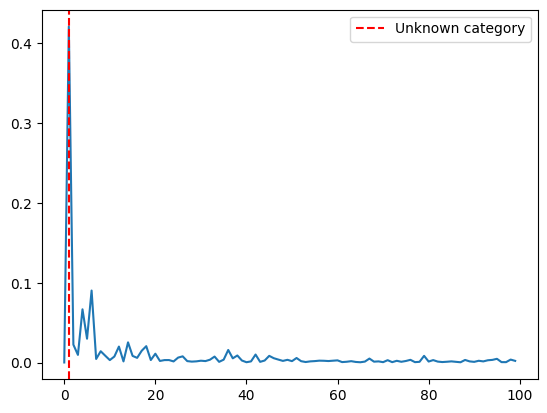

In [33]:
from matplotlib import pyplot as plt
plt.plot(yhat[100])
plt.axvline(x = 1, label = "Unknown category", color = 'red', linestyle = 'dashed')
plt.legend()
plt.show

In [34]:
np.sum(np.argmax(model.predict(X_val), axis = 1)!=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


222

## 3. SimpleRNN
### Exercise 9 
Fit a NN with a `SimpleRNN` layer.

In [42]:
input = tf.keras.Input(shape=(sequence_length,), dtype="int64") 
emd = layers.CategoryEncoding(num_tokens=vocab_size, output_mode='one_hot')(input)
x = layers.SimpleRNN(32)(emd) 
output = layers.Dense(vocab_size, activation="softmax")(x) 
model = tf.keras.Model(input, output) 

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ category_encoding_4                  │ (None, 5, 100)              │               0 │
│ (CategoryEncoding)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 32)                  │           4,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │           3,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,556 (29.52 KB)

 Trainable params: 7,556 (29.52 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs = 10, 
    batch_size=128) 

Epoch 1/10


ValueError: Could not interpret metric identifier: AIC

In [59]:
np.sum(np.argmax(model.predict(X_val), axis = 1)!=1)

125/125 [==============================] - 0s 748us/step


2

## 4. LSTM
### Exercise 10
Fit a NN with a `LSTM` layer.

In [60]:
input = tf.keras.Input(shape=(sequence_length,), dtype="int64") 
emd = tf.one_hot(input, depth=vocab_size)
x = layers.LSTM(32)(emd) 
output = layers.Dense(vocab_size, activation="softmax")(x) 
model = tf.keras.Model(input, output) 

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5)]               0         
                                                                 
 tf.one_hot_2 (TFOpLambda)   (None, 5, 100)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_3 (Dense)             (None, 100)               3300      
                                                                 
Total params: 20,324
Trainable params: 20,324
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs = 10, 
    batch_size=128) 

Epoch 1/10
175/175 [==============================] - 2s 5ms/step - loss: 3.1338 - accuracy: 0.4934 - val_loss: 2.6688 - val_accuracy: 0.4974
Epoch 2/10
175/175 [==============================] - 1s 3ms/step - loss: 2.6701 - accuracy: 0.5011 - val_loss: 2.6611 - val_accuracy: 0.4974
Epoch 3/10
175/175 [==============================] - 1s 3ms/step - loss: 2.6612 - accuracy: 0.5011 - val_loss: 2.6666 - val_accuracy: 0.4974
Epoch 4/10
175/175 [==============================] - 0s 3ms/step - loss: 2.6526 - accuracy: 0.5011 - val_loss: 2.6457 - val_accuracy: 0.4974
Epoch 5/10
175/175 [==============================] - 0s 3ms/step - loss: 2.6446 - accuracy: 0.5011 - val_loss: 2.6535 - val_accuracy: 0.4974
Epoch 6/10
175/175 [==============================] - 0s 3ms/step - loss: 2.6369 - accuracy: 0.5011 - val_loss: 2.6459 - val_accuracy: 0.4974
Epoch 7/10
175/175 [==============================] - 1s 3ms/step - loss: 2.6285 - accuracy: 0.5011 - val_loss: 2.6285 - val_accuracy: 0.4974
Epoch 

In [63]:
np.sum(np.argmax(model.predict(X_val), axis = 1)!=1)

125/125 [==============================] - 0s 957us/step


0

## 5. Embedding + LSTM
### Exercise 11
Fit a NN with an `Embedding` and `LSTM` layers.

In [76]:
input = tf.keras.Input(shape=(sequence_length,), dtype="int64") 
emd = layers.Embedding(input_dim=vocab_size, output_dim=16)(input)
x = layers.LSTM(32)(emd) 
output = layers.Dense(vocab_size, activation="softmax")(x) 
model = tf.keras.Model(input, output) 

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding_3 (Embedding)     (None, 5, 16)             1600      
                                                                 
 lstm_4 (LSTM)               (None, 32)                6272      
                                                                 
 dense_7 (Dense)             (None, 100)               3300      
                                                                 
Total params: 11,172
Trainable params: 11,172
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs = 10, 
    batch_size=64) 

Epoch 1/10
349/349 [==============================] - 2s 3ms/step - loss: 2.9095 - accuracy: 0.4995 - val_loss: 2.6744 - val_accuracy: 0.4974
Epoch 2/10
349/349 [==============================] - 1s 2ms/step - loss: 2.6674 - accuracy: 0.5011 - val_loss: 2.6702 - val_accuracy: 0.4974
Epoch 3/10
349/349 [==============================] - 1s 2ms/step - loss: 2.6484 - accuracy: 0.5011 - val_loss: 2.6391 - val_accuracy: 0.4974
Epoch 4/10
349/349 [==============================] - 1s 2ms/step - loss: 2.6317 - accuracy: 0.5011 - val_loss: 2.6472 - val_accuracy: 0.4974
Epoch 5/10
349/349 [==============================] - 1s 2ms/step - loss: 2.6192 - accuracy: 0.5011 - val_loss: 2.6281 - val_accuracy: 0.4974
Epoch 6/10
349/349 [==============================] - 1s 2ms/step - loss: 2.6012 - accuracy: 0.5011 - val_loss: 2.5927 - val_accuracy: 0.4974
Epoch 7/10
349/349 [==============================] - 1s 2ms/step - loss: 2.5761 - accuracy: 0.5011 - val_loss: 2.5668 - val_accuracy: 0.4974
Epoch 

In [79]:
np.sum(np.argmax(model.predict(X_val), axis = 1)!=1)

125/125 [==============================] - 0s 1ms/step


0